<a href="https://colab.research.google.com/github/KevinLolochum/dotfiles/blob/master/Toronto_Parking_Data_Forecasting_revenue_using_Recurrent_Neural_Networks_RNNs(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Below, I use the publicly available toronto city data to predict and give recommendations on parking revenue and compliance/enforcement.
Revenue is measured by amount of fine.
I am assuming that small fines and reduced frequency of fines indiicate compliance.

In addition to parking data, I also add the publicly available data on seasons, weather and public holidays as features/variables in my model.

Data sources

1. Canadian holidays dataset https://github.com/uWaterloo/Datasets/blob/master/Holidays/holidays.csv  
2. Toronto temp and seasons dataset https://www.kaggle.com/rainbowgirl/climate-data-toronto-19372018
and https://toronto.weatherstats.ca/download.html
3. Parking tickets  https://open.toronto.ca/dataset/parking-tickets/

Some assumptions include
1. All canadian holidays are celebrated in Toronto


In [ ]:
# Importing useful libraries

# For data analysis and visualization
import pandas as pd
import numpy as np
import glob
# for ML and DL
import tensorflow as ts
import keras

In [ ]:
# Connecting to Gdrive to aceess data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading and combining the parking dataset that is spread over 13 periods

Currecntly suspended from using colab so my notebook can't access google drive.

In [ ]:
# Join all the dataframes as you upload, 
# Alternatively use sorted(glob.glob) and loops to name then concat (slower and takes more RAM space)
Parking = pd.concat ([pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2015_1.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2015_2.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2015_3.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2016_1.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2016_2.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2016_3.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2016_4.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2017_1.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2017_2.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2017_3.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2018_1.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2018_2.csv'),
                     pd.read_csv('/content/gdrive/My Drive/Parking_Tags_Data_2018_3.csv')])

Parking.head(2)


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***87325,20150101,15.0,PARK-WITHIN 3M OF FIRE HYDRANT,100,1.0,OPP,11 CENTRE AVE,NaN,NaN,ON
1,***87326,20150101,15.0,PARK-WITHIN 3M OF FIRE HYDRANT,100,1.0,OPP,11 CENTRE AVE,NaN,NaN,ON


Exploring output

In [ ]:
#Checking the shape of data
Parking.shape

(8611768, 11)

In [ ]:
Parking.isna().sum()

tag_number_masked               0
date_of_infraction              0
infraction_code                 2
infraction_description          0
set_fine_amount                 0
time_of_infraction           5667
location1                  712263
location2                    1318
location3                 8034965
location4                 8032911
province                        2
dtype: int64

In [ ]:
#Column datatypes
Parking.dtypes

tag_number_masked          object
date_of_infraction          int64
infraction_code           float64
infraction_description     object
set_fine_amount             int64
time_of_infraction        float64
location1                  object
location2                  object
location3                  object
location4                  object
province                   object
dtype: object

From exploration, it seems that the most important data fine amount and data. 

Location have too much cardinality and missing values thus wont be meanigful for our predictions. 

This could be improved by reducing location to a few regions (e.g Downtown, midtown etc)

Time in hours and minutes is not important for two reasons.
1. Time is not well captures in the dataset (first quarter times for each year)
2. Predicting revenue per hour/minute might not be be important for the businesss
For the above reasons I will aggregate/reshape revenue by day going forward.


In [ ]:
# Converting date of infraction to date and set as index
Parking.date_of_infraction = pd.to_datetime(Parking['date_of_infraction'], format='%Y%m%d', errors='ignore')
dfr = Parking.set_index('date_of_infraction')

# Aggregate fine amount by date, change to dataframe and rename as revenue

dfx = dfr['set_fine_amount'].resample('d').sum()
dfs = pd.DataFrame(dfx)
dfs = dfs.rename(columns={'set_fine_amount': 'Revenue'})
dfs.head(3)

# A more robust model could be created by hourly aggregation but hourly data is messy

,Revenue
date_of_infraction,
2015-01-01,79975
2015-01-02,315130
2015-01-03,194880


In [ ]:
dfs.dtypes

Revenue    int64
dtype: object

## Additional data - Weather, Holidays and Seasons

Data sources are indicated above. Some cleaning of this data in excel.

In [ ]:
# Loading from drive
Data = pd.read_csv('/content/gdrive/My Drive/Toronto_weather_and_holidays.csv', delimiter=',', parse_dates=True)

# Set date as index

Data['DATE'] = pd.to_datetime(Data[['Year', 'Month', 'Day']])
Data = Data.set_index('DATE')
Data.pop('Date')
Data.head(3)

,Year,Month,Day,Temp,Rain,Snow,Precip,season,Holiday,Is_holiday
DATE,,,,,,,,,,
2018-01-01,2018,1,1,-15,0,0,0,Winter,New Year's Day,1
2018-01-02,2018,1,2,-11,0,1,1,Winter,NaN,0
2018-01-03,2018,1,3,-10,0,0,0,Winter,NaN,0


Combining the two datasets form our final dataset

In [ ]:
# Pd.merge on date combines horizontally and also implements cross join if
df = pd.merge(Data, dfs, left_index=True, right_index=True)
df.head(3)


,Year,Month,Day,Temp,Rain,Snow,Precip,season,Holiday,Is_holiday,Revenue
2018-01-01,2018,1,1,-15,0,0,0,Winter,New Year's Day,1,63490
2018-01-02,2018,1,2,-11,0,1,1,Winter,NaN,0,285635
2018-01-03,2018,1,3,-10,0,0,0,Winter,NaN,0,278120


In [ ]:
df.shape

(1461, 11)

In [ ]:
# Changing holiday to categorical
df['Is_holiday'] = df['Is_holiday'].astype('uint8')

Downloading data to excel to be used for power BI Analysis

In [ ]:
#df.to_excel("Toronto_Parking_Data.xlsx", index=True, encoding='utf8')

A little more cleaning

In [ ]:

# This are the most important columns for our model
df1 = df[['Month','Day','Temp', 'Rain', 'Snow', 'Precip', 'season', 'Is_holiday',  'Revenue']]


# one-hot encoding seasons and setting a date index with the same length as our data
df2 = pd.get_dummies(df1['season'])
df2.set_index(keys = pd.date_range('01/01/2015','12/31/2018', periods=1461))

# Merging the dummies dataset and the real dataset using index
df3 = pd.merge(df1,df2, left_index=True, right_index=True)

# Don't need seasons anymore
df3.pop('season')
df3.head(2)


,Month,Day,Temp,Rain,Snow,Precip,Is_holiday,Revenue,Fall,Spring,Summer,Winter
2018-01-01,1,1,-15,0,0,0,1,63490,0,0,0,1
2018-01-02,1,2,-11,0,1,1,0,285635,0,0,0,1


In [ ]:
# datatypes look good
df3.dtypes

Month         int64
Day           int64
Temp          int64
Rain          int64
Snow          int64
Precip        int64
Is_holiday    uint8
Revenue       int64
Fall          uint8
Spring        uint8
Summer        uint8
Winter        uint8
dtype: object

In [ ]:
# No null values, Data looks good to try some models
df3.isna().sum()

Month         0
Day           0
Temp          0
Rain          0
Snow          0
Precip        0
Is_holiday    0
Revenue       0
Fall          0
Spring        0
Summer        0
Winter        0
dtype: int64

## Exploratory Analysis

This section will help me decide which model is best for this problem

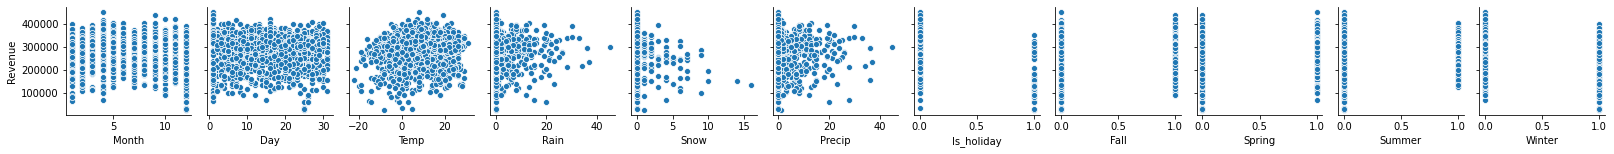

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['Month', 'Day', 'Temp', 'Rain', 'Snow', 'Precip', 'Is_holiday', 'Fall', 'Spring', 'Summer', 'Winter']

sns.pairplot(df3, x_vars = columns , 
             y_vars = 'Revenue', height = 2);

There is some linear relationship between weather conditions and revenue. For instance, as precipitation increases revenue collected per day seems to be larger as shown by the dots trending to upper left. However, dots are less clustered showing that there are fewer days with that amount of predipitation.

There is almost no relationship between revenue collected and day of the month. Day of the week could be different but we will have to encode another 7 different variables.

# Modelling

Even though my analysis above indicate indicate that there is some linear relationship between revenue and some some features, this data perfomed very bad on linear models even after regularization. The R_squared (coefficient of determination) for the best linear model was 0.1815.

After testing a few other models such as SVR I decided to use a LSTM time series forecasting model, which performed pretty well as shown below.


## LSTM MODEL

LSTM is ideal for this problem because we are trying to predict future values using current and past values.

LSTM can remember values from the past when they are important and forget when they are no longer important. This is great for example because as seasons and weather change our model will know not to put so much weight on conditions such as snow or precipitation when making predictions.

In [ ]:
# Rearranging columns for prediction

df4 = df3[['Temp', 'Rain', 'Snow', 'Precip', 'Is_holiday', 'Fall', 'Spring', 'Summer', 'Winter', 'Revenue']]


In [ ]:
# This change to my dataset is implemented after I realized my data is too small for the model
# I am downscaling revenue to minute level by deviding daily revenue by minutes in a day.
# I already assume weather conditions don't change significantly to affect revenue collection in a day
df4 = df4.resample('1Min').ffill()
df4['Revenue'] = df4['Revenue']/(24*60)
df4.head(3)


,Temp,Rain,Snow,Precip,Is_holiday,Fall,Spring,Summer,Winter,Revenue
2015-01-01 00:00:00,-5,0,0,0,1,0,0,0,1,55.538194
2015-01-01 00:01:00,-5,0,0,0,1,0,0,0,1,55.538194
2015-01-01 00:02:00,-5,0,0,0,1,0,0,0,1,55.538194


In [ ]:
# Now we have a much larger dataset
df4.shape

(1461, 10)

To apply LSTM I need to convert the time_series data to supervised learning problem

This long code does the following.

1. Takes our data and naively forecasts the next value for each column by simply shifting the current value to one period in future.

   i.e we are predicting values at time (t) & t(1-n) using past values. for both outputs and inputs.
2. Aggegates the columns and deletes null values created by shifting values forward.
3. Does this for both inputs and outputs.

In [ ]:

# prepare data for lstm
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split
 
# convert series to supervised learning

def dataframe_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# n_in, n_out define the lag of input and output, I can increase if I want to predict deeper into the future
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
 
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Col%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Col%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Col%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
  # put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	
  # drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
# Convert  dataframe to numpy array to easily normalize everything
values = df4.values 

# Make data float for normalization
values = values.astype('float32')

# normalize features for model convinience
# model does not work well with large vales
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# Transforming our dataset into a supervised learning problem using the function
# Columns Colx(t-x) represented the forecated values for Colx(t) for the dataset

df5 = dataframe_to_supervised(scaled)
df5.head(3)

,Col1(t-1),Col2(t-1),Col3(t-1),Col4(t-1),Col5(t-1),Col6(t-1),Col7(t-1),Col8(t-1),Col9(t-1),Col10(t-1),Col1(t),Col2(t),Col3(t),Col4(t),Col5(t),Col6(t),Col7(t),Col8(t),Col9(t),Col10(t)
1,0.132075,0.0,0.0000,0.000000,1.0,0.0,0.0,0.0,1.0,0.088383,0.207547,0.0,0.0625,0.022222,0.0,0.0,0.0,0.0,1.0,0.609038
2,0.207547,0.0,0.0625,0.022222,0.0,0.0,0.0,0.0,1.0,0.609038,0.226415,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.591424
3,0.226415,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.591424,0.132075,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.564483


The new dataset is constructed as a DataFrame, with each column suitably named both by variable number and time step. This allows you to design a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series

In [ ]:
df6 = df5[['Col10(t-1)', 'Col1(t-1)', 'Col2(t-1)', 'Col3(t-1)', 
           'Col4(t-1)', 'Col5(t-1)', 'Col6(t-1)', 'Col7(t-1)', 'Col8(t-1)', 'Col9(t-1)', 'Col10(t)' ]]

df6.head(3)


,Col10(t-1),Col1(t-1),Col2(t-1),Col3(t-1),Col4(t-1),Col5(t-1),Col6(t-1),Col7(t-1),Col8(t-1),Col9(t-1),Col10(t)
1,0.088383,0.132075,0.0,0.0000,0.000000,1.0,0.0,0.0,0.0,1.0,0.609038
2,0.609038,0.207547,0.0,0.0625,0.022222,0.0,0.0,0.0,0.0,1.0,0.591424
3,0.591424,0.226415,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.564483


In [ ]:
# I need a numpy array of values to proceed
values2 = df6.values

#Split to train and test
Len = int(len(values2)*0.8)
train = values2[:Len, :]
test = values2[Len:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1168, 1, 10) (1168,) (292, 1, 10) (292,)


Creating the LSTM Model

In [ ]:

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Creating/Initializing

model = Sequential()
model.add(LSTM(50, input_shape=(1, 10), return_sequences= True, stateful= False))
model.add(Dense(1))

# Compiling
model.compile(loss='mae', optimizer='adam')



Fitting model and evalueting to see accuracy

Epoch 1/10
24/24 [==============================] - 0s 18ms/step - loss: 0.4935 - val_loss: 0.3198
Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 0.2500 - val_loss: 0.1256
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 0.1373 - val_loss: 0.1238
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 0.1228 - val_loss: 0.1087
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.1200 - val_loss: 0.1086
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 0.1191 - val_loss: 0.1074
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 0.1184 - val_loss: 0.1073
Epoch 8/10
24/24 [==============================] - 0s 4ms/step - loss: 0.1179 - val_loss: 0.1065
Epoch 9/10
24/24 [==============================] - 0s 4ms/step - loss: 0.1181 - val_loss: 0.1077
Epoch 10/10
24/24 [==============================] - 0s 4ms/step - loss: 0.1174 - val_loss: 0.1033


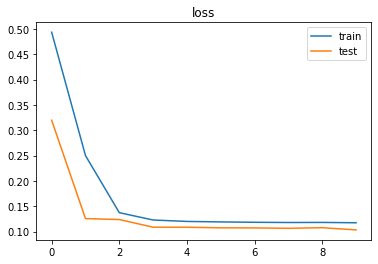

In [ ]:
# params

epochs = 10
BATCH_SIZE = 50
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size= BATCH_SIZE, validation_data=(test_X, test_y), verbose=1, shuffle=True)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss')
plt.legend()
plt.show()


Evaluating model

In [ ]:

from pandas import DataFrame
from pandas import concat
from numpy import concatenate

# Predicting Y values using our test data
yhat = model.predict(test_X)

# Reshape yhat and test_X to 2D in order to combine the two
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
Newtest_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Combine and trenasform to original values (denormalize)
inv_yhat = concatenate((Newtest_X[:, 1:], yhat), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat)


In [ ]:
# Invert actual Y values to original scale
Newtest_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((Newtest_X[:, 1:], Newtest_y), axis=1)
inv_y2 = scaler.inverse_transform(inv_y)

NameError: ignored

In [ ]:
# calculating RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.851


Model achieves respectable RMSE of 22.81, showing that there is  I could improve this model by doing using more data.